In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import ArgumentParser, Namespace
import pandas as pd
import torch
import torch.nn as nn
from src.hall_tools import models_and_dataset, ssim
from src.plot import show

In [3]:
# Arguments
args = Namespace(sisr=False,
                 model = 'FSRCNN', #only necessary if SISR
                 batch_size=8,
                 clouds=False,
                 shiftnet=True)

In [4]:
# MFSR Checkpoints
filepaths = []
filepaths += ["/home/muhammed/gs_models/hrnet_MAE_en2-epoch=24-step=46874.ckpt"]
filepaths += ["/home/muhammed/gs_models/hrnet_SSIM_en1-epoch=24-step=46874.ckpt"]
filepaths += ["/home/muhammed/gs_models/hrnet_SSIM_en3-epoch=24-step=46874.ckpt"]
filepaths += ["/home/muhammed/gs_models/hrnet_SSIM_en0-epoch=24-step=46874.ckpt"]

In [5]:
# load ensemble weights and datamodule
models, dm = models_and_dataset(args, ensemble_checkpoints=filepaths)

In [15]:
# compute predictions
upsample_layer = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2.094, align_corners=False))
with torch.no_grad():
    for idx, batch in enumerate(dm.val_dataloader()):
        if idx == 0:
            highres = batch['highres']
            lowres = batch['lowres']

#           Choose best lowres images for either SISR or for comparison
            indices = (lowres['clearances']).argmax(1)
            lowres_images = lowres['images'][torch.arange(len(indices)),indices,...]
#             else:
#                 lowres_images = lowres['images']
            
            same_size_lowres = upsample_layer(lowres_images)
            highres_images = highres['images'].squeeze(1)
            B, C, H, W = highres_images.shape
            T = len(models)
            predictions = torch.zeros((T, B, C, H, W))
            for idx, m in enumerate(models):
                if args.sisr:
                    predictions[idx] = m(lowres_images)
                else:
                    predictions[idx] = m(lowres)
            # B, T, C, H, W
            predictions = predictions.transpose(1,0)
            break
        else:
            pass

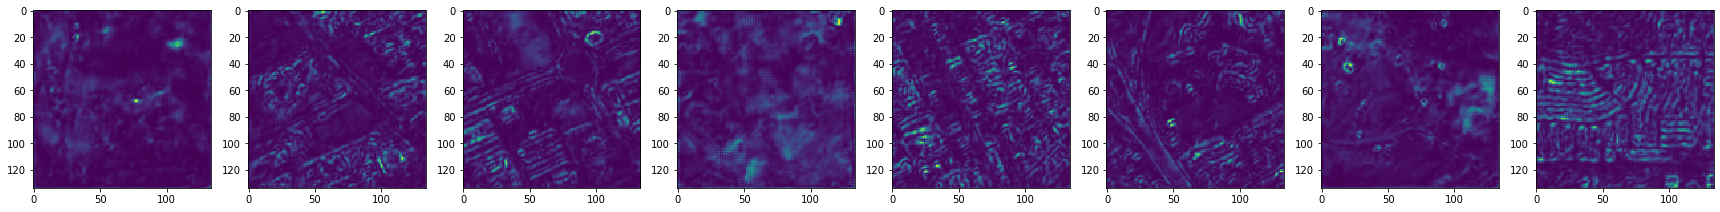

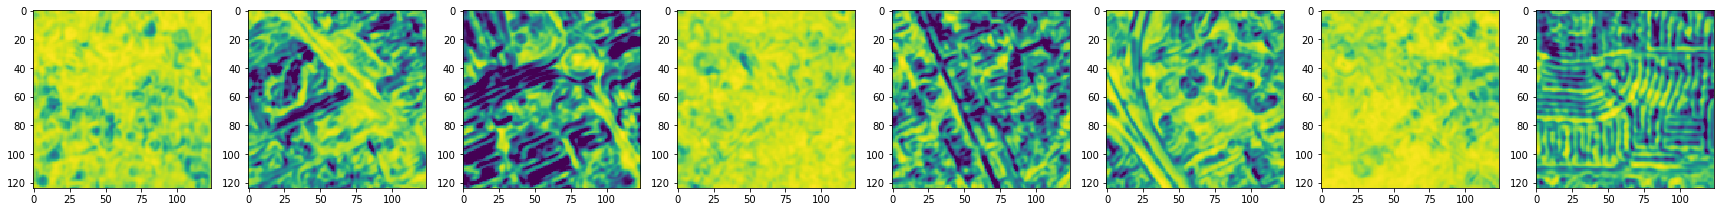

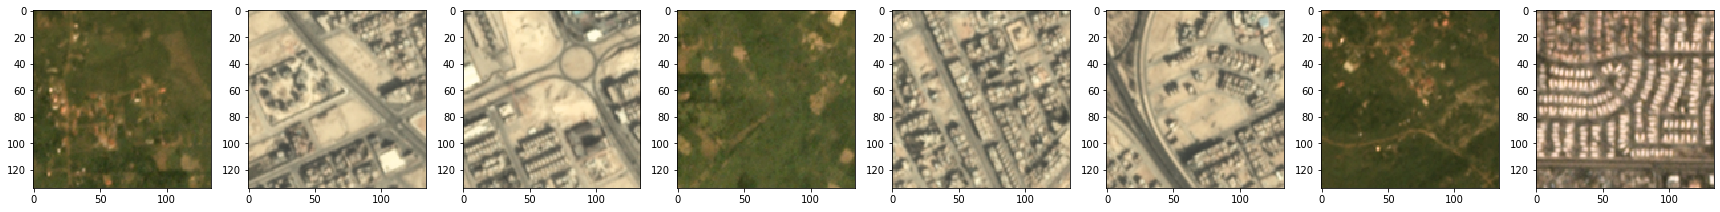

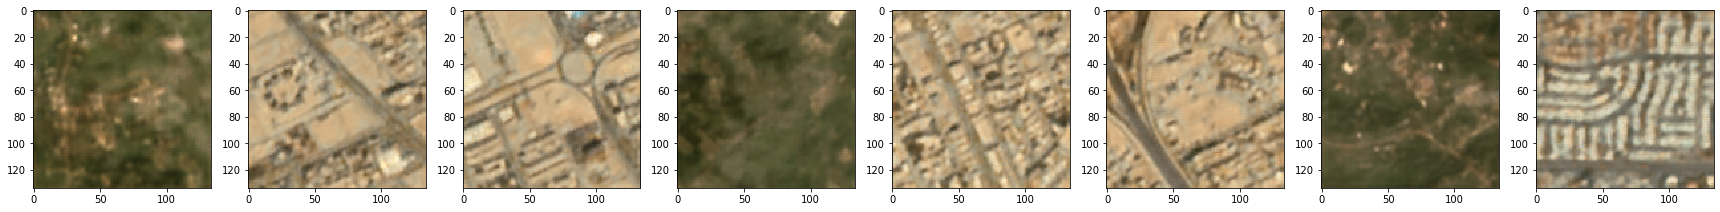

In [24]:
# display predictions
variance = torch.mean(torch.var(predictions, dim=1), dim=1).unsqueeze(1)
ssim_highres = ssim(torch.mean(predictions,dim=1).squeeze(1), highres['images'].squeeze(1), kernel_size=11)

show(variance)
show(ssim_highres.unsqueeze(1))
show(highres['images'].squeeze())
show(predictions[:,0,...])

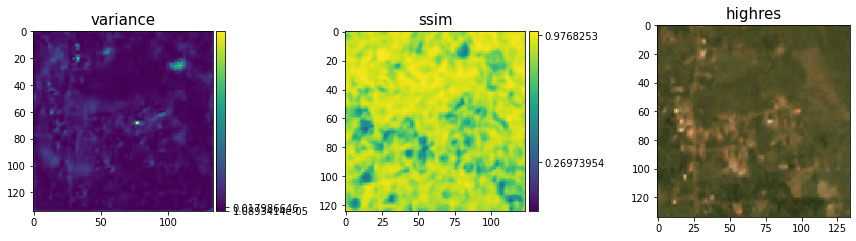

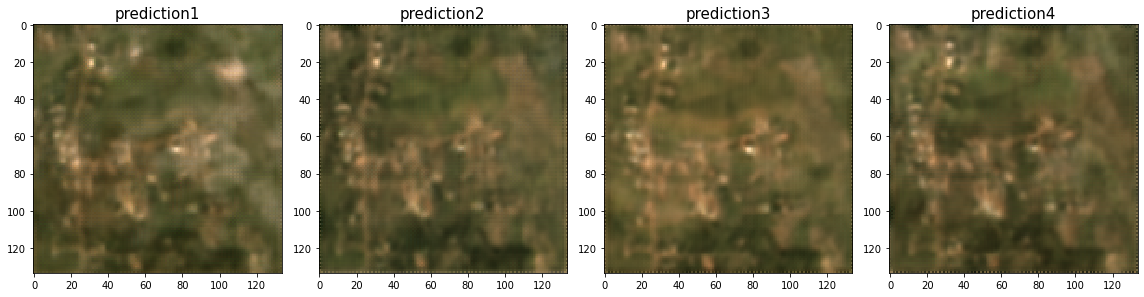

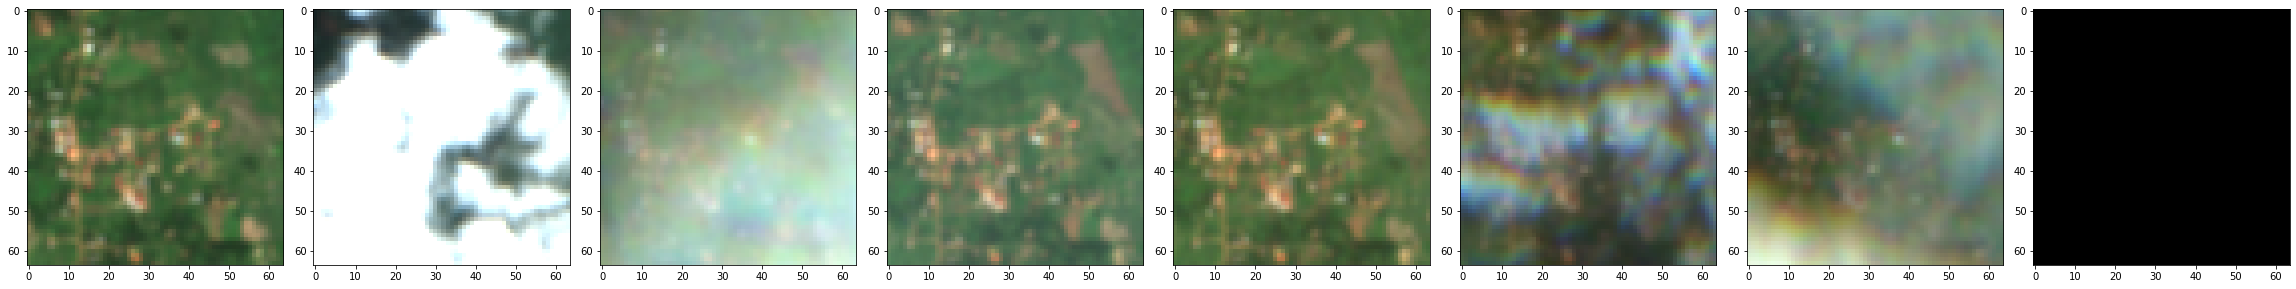

In [29]:
# show single example
i = 0
show([variance[i], ssim_highres[i], highres['images'].squeeze()[i]], colorbar=True, title=['variance', 'ssim', 'highres'], figsize=4)
show(predictions[i,...], figsize=4, title=['prediction1', 'prediction2', 'prediction3', 'prediction4'])
show(lowres['images'][i], figsize=4)

In [ ]:
# For SISR
i = 2

variance = torch.mean(torch.var(predictions, dim=1), dim=1).unsqueeze(1)[i]
ssim_highres = ssim(torch.tensor(predictions[i]), torch.tensor(highres['images'][i]), kernel_size=11)
ssim_lowres = ssim(torch.tensor(predictions[i]),  same_size_lowres[i], kernel_size=11)
show([variance, ssim_highres, ssim_lowres], colorbar=True, title=['variance', 'ssim', 'ssim_lowres'], figsize=5)
show([same_size_lowres[i], highres_images[i]], title=['lowres', 'highres'], figsize=4)
show(predictions[i,...], title=['prediction1', 'prediction2', 'prediction3', 'prediction4'])